In [1]:
import pathlib, copy, re, pickle
from itertools import product
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.ticker as mtick
import seaborn as sns
from Bio import Phylo
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION, length_distributions
from elyawy.sparta import Msa
import raxml_parser
from sklearn.base import BaseEstimator, TransformerMixin# define the transformer

class StandardMemoryScaler(BaseEstimator, TransformerMixin):

    def __init__(self, epsilon=1e-4):
        self._epsilon = epsilon
        
    def fit(self, X, y = None):
        self._mean = X.mean()
        self._std = X.std()

        return self

    def transform(self, X):
        X = (X-self._mean)/(self._std+self._epsilon)
       
        return X


In [2]:
def fetch_paths(current_path: pathlib.Path):
    if len( n := list(current_path.glob("*.tree"))) == 1:
        tree_path = n[0]

    if len( n := list(current_path.glob("*.fasta"))) == 1:
        msa_path = n[0]

    if tree_path is None or msa_path is None:
        print("no fasta or tree file")
        exit()
    return tree_path, msa_path

In [3]:
RESULTS_PATH = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results").resolve() # sys.argv[2]
CLASSIFICATIONS = {}
CLASSIFICATIONS["eggnog"] = pd.read_csv(RESULTS_PATH / "eggnog_classifications.csv", index_col="index")["0"]
CLASSIFICATIONS["yeast"] = pd.read_csv(RESULTS_PATH / "yeast_classifications.csv", index_col="index")["0"]
# CLASSIFICATIONS["adequacy_sims"] = pd.read_csv(RESULTS_PATH / "adequacy_sims_classifications.csv", index_col="index")["0"]


In [4]:
def get_percentile_summary(sims_df, empirical_df):
    to_df = {}
    for sum_stat in filter(lambda x: "SS" in x, sims_df.columns):
        percentile = stats.percentileofscore(sims_df[sum_stat], empirical_df[sum_stat], kind="weak")
        stat_def = SUMSTATS_DEFINITION[sum_stat].replace("\n", "_")#.replace("_"," ").title()
        to_df[stat_def] =  [sum_stat, empirical_df[sum_stat], percentile]
    
    percentile_summary =  pd.DataFrame(to_df,index=["stat_id","empirical","percentile"]).T
    percentile_summary["retained"] = (percentile_summary.percentile.between(2.5,97.5)).astype(int)

    return percentile_summary

p_val_limits_corrected = (0.0 + 0.05/(2*len(SUMSTATS_LIST)), 1.0 - 0.05/(2*len(SUMSTATS_LIST))) # bonferroni correction
p_val_limits = (0.0 + (0.05/2), 1.0 - (0.05/2)) # bonferroni correction

print(p_val_limits)

(0.025, 0.975)


make a comparison per summary statistic - no correction, and per dataset - with correction.

In [ ]:
Brassicales_3HQ7D

In [8]:
SELECTED_DATA = "Bacillus_1ZQHG"
EGGNOG_PATH = RESULTS_PATH / "eggnog" / SELECTED_DATA
SIMS_PATH = next((RESULTS_PATH / "adequacy_revised").glob(f"{SELECTED_DATA}_*"))
_, EMPIRICAL_MSA_PATH = fetch_paths(EGGNOG_PATH)
_, SIM_MSA_PATH = fetch_paths(SIMS_PATH)

StopIteration: 

In [7]:
EMPIRICAL_MSA = Msa(str(EMPIRICAL_MSA_PATH))
SIM_MSA = Msa(str(SIM_MSA_PATH))

adequacy_eggnog = pd.read_csv(EGGNOG_PATH / "adequacy_revised/zipf_corrected.csv").drop(columns="Unnamed: 0")
adequacy_sims = pd.read_csv(SIMS_PATH / "adequacy_revised/zipf_corrected.csv").drop(columns="Unnamed: 0")

In [8]:
empirical_sum_stats = EMPIRICAL_MSA.get_sum_stats()
empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))

sim_sum_stats = SIM_MSA.get_sum_stats()
sim_sum_stats = dict(zip(SUMSTATS_LIST, sim_sum_stats))

print(empirical_sum_stats)
print(sim_sum_stats)


{'SS_0': 15.691489361702128, 'SS_1': 806.0, 'SS_2': 795.0, 'SS_3': 146.0, 'SS_4': 94.0, 'SS_5': 31.0, 'SS_6': 26.0, 'SS_7': 3.0, 'SS_8': 34.0, 'SS_9': 44.714285714285715, 'SS_10': 28.0, 'SS_11': 5.0, 'SS_12': 0.0, 'SS_13': 1.0, 'SS_14': 0.0, 'SS_15': 0.0, 'SS_16': 0.0, 'SS_17': 1.0, 'SS_18': 1.0, 'SS_19': 0.0, 'SS_20': 8.0, 'SS_21': 4.0, 'SS_22': 0.0, 'SS_23': 138.0, 'SS_24': 159.0, 'SS_25': 448.0, 'SS_26': 15.0}
{'SS_0': 12.658536585365853, 'SS_1': 174.0, 'SS_2': 143.0, 'SS_3': 121.0, 'SS_4': 41.0, 'SS_5': 9.0, 'SS_6': 2.0, 'SS_7': 0.0, 'SS_8': 30.0, 'SS_9': 10.818181818181818, 'SS_10': 11.0, 'SS_11': 2.0, 'SS_12': 0.0, 'SS_13': 0.0, 'SS_14': 0.0, 'SS_15': 1.0, 'SS_16': 0.0, 'SS_17': 0.0, 'SS_18': 0.0, 'SS_19': 0.0, 'SS_20': 1.0, 'SS_21': 0.0, 'SS_22': 0.0, 'SS_23': 87.0, 'SS_24': 32.0, 'SS_25': 0.0, 'SS_26': 29.0}


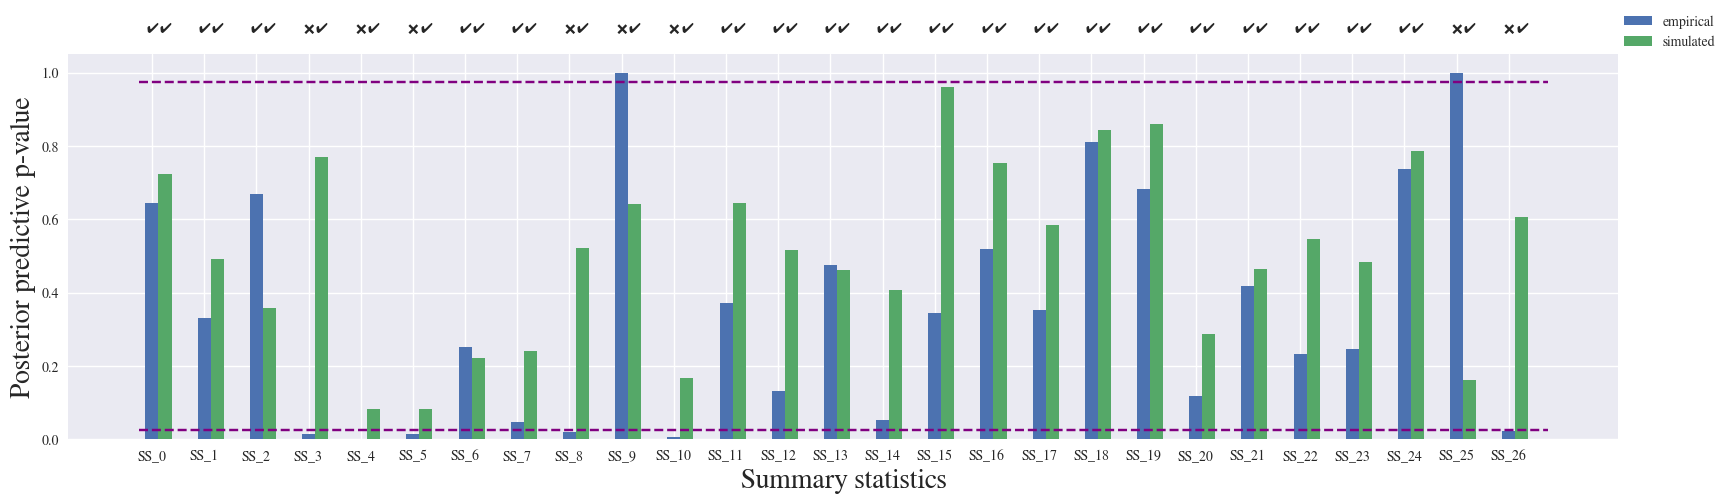

In [9]:
empirical_percentile_summary = get_percentile_summary(adequacy_eggnog, empirical_sum_stats)
sim_percentile_summary = get_percentile_summary(adequacy_sims, sim_sum_stats)

x = np.arange(len(sim_percentile_summary))
width = 0.25
plt.rcParams['font.sans-serif'] = ['FreeSerif']
plt.rcParams['font.serif'] = ['FreeSans']
plt.rcParams['axes.unicode_minus'] = False

bar1 = plt.bar(x+width, empirical_percentile_summary["percentile"]/100, width=width, label="empirical")
bar2 = plt.bar(x+width*2, sim_percentile_summary["percentile"]/100, width=width, label="simulated")


line = plt.Line2D(xdata=(x[0], x[-1]+1), ydata=(p_val_limits[0],p_val_limits[0]), linestyle="--", color="purple")
plt.gca().add_line(line)

line = plt.Line2D(xdata=(x[0], x[-1]+1), ydata=(p_val_limits[1],p_val_limits[1]), linestyle="--", color="purple")
plt.gca().add_line(line)

for rect in bar1 + bar2:
    height = rect.get_height()
    txt = "✔" if height < p_val_limits[1] and height > p_val_limits[0] else "❌"
    plt.text(rect.get_x() + rect.get_width() / 2.0, 1.1, txt, ha='center', va='bottom')


plt.xticks(x + width, SUMSTATS_LIST)
plt.gcf().set_size_inches(20,5)

plt.ylabel("Posterior predictive p-value", size=20)
plt.xlabel("Summary statistics", size=20)
plt.legend(loc=(1.0,1.0))

plt.show()

In [10]:
stats_df = adequacy_sims.loc[:,"SS_0":"SS_26"]
sims_stats_scaled = (stats_df-stats_df.min())/(stats_df.max()-stats_df.min())
# sims_stats_scaled = (stats_df-stats_df.mean())/stats_df.std()
stats_df = adequacy_eggnog.loc[:,"SS_0":"SS_26"]
empirical_stats_scaled = (stats_df-stats_df.min())/(stats_df.max()-stats_df.min())
# eggnog_stats_scaled = (stats_df-stats_df.mean())/stats_df.std()


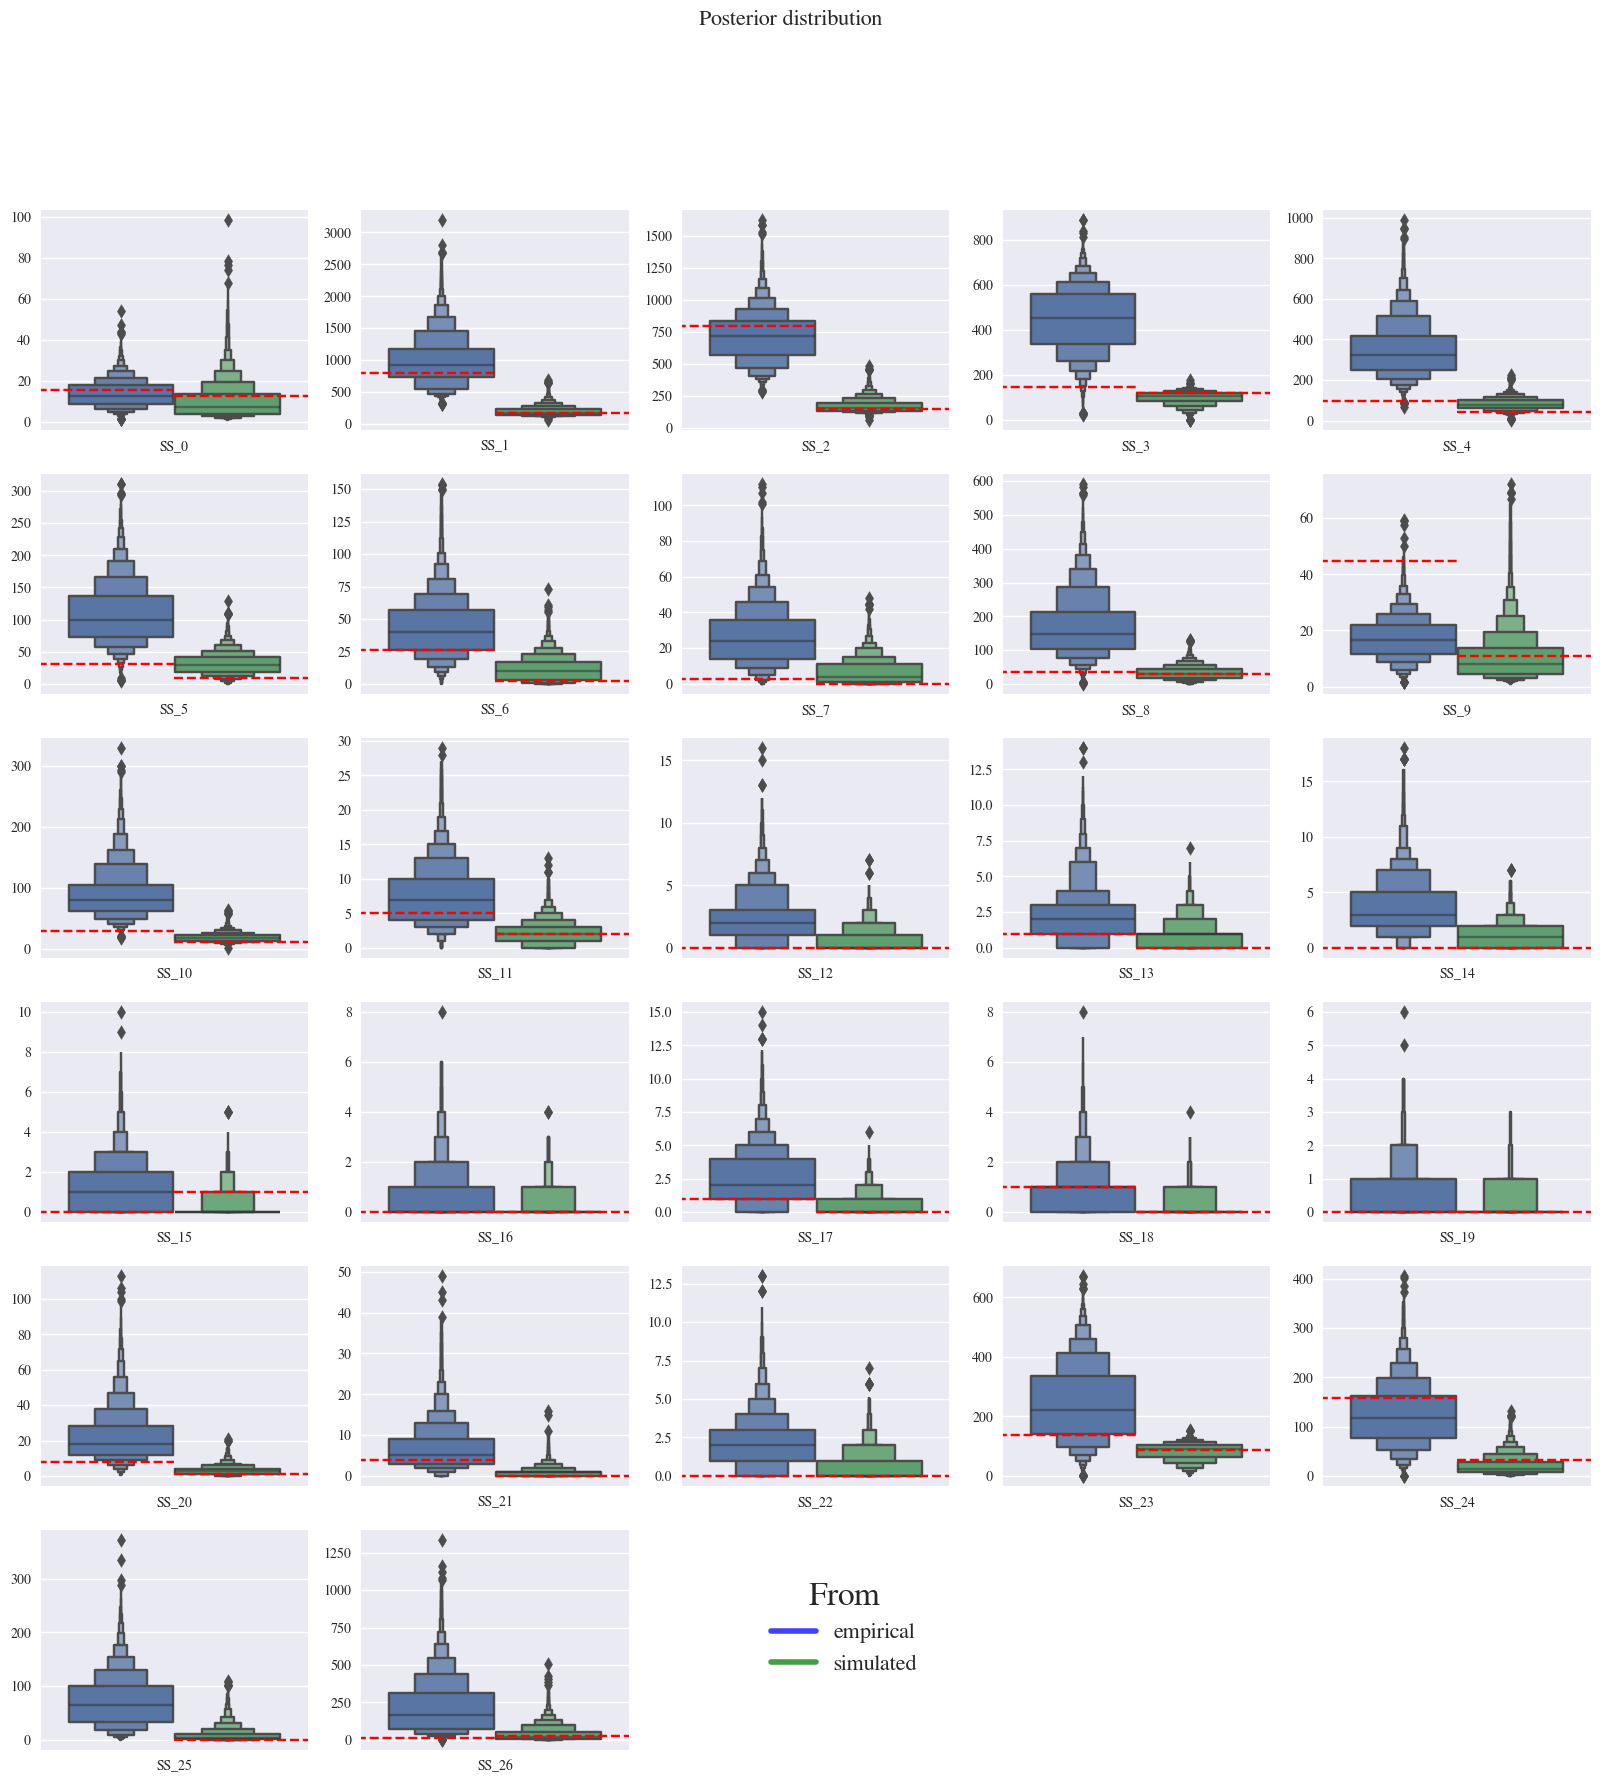

In [10]:
# merged_df = pd.concat([empirical_stats_scaled.stack().to_frame(), sims_stats_scaled.stack().to_frame()])
merged_df = pd.concat([adequacy_eggnog[SUMSTATS_LIST].stack().to_frame(), adequacy_sims[SUMSTATS_LIST].stack().to_frame()])

merged_df["from"] = ["empirical"]*(len(merged_df)//2) + ["simulation"]*(len(merged_df)//2)

merged_df = merged_df.reset_index().drop(labels="level_0", axis=1)

merged_df.columns = ["stat", "value", "from"]

legend_elements = [plt.Line2D([0], [0], color=x[0], lw=4, label=x[1], alpha=0.75) for x in [("blue", "empirical"),("green", "simulated")]]

fig, axs = plt.subplots(6,5)
fig.set_size_inches((20, 20))
axs = axs.flatten()
[ax.remove() for ax in axs[len(SUMSTATS_LIST):]]
axs = axs[:len(SUMSTATS_LIST)]

for idx,ax in enumerate(axs):
    current_stat = f"SS_{idx}"
    current_df = merged_df[merged_df.stat == current_stat]
    sns.boxenplot(data=current_df, x="stat", y="value", hue="from" , ax=ax)

    line = plt.Line2D(xdata=(-1,0),ydata=(empirical_sum_stats[current_stat],empirical_sum_stats[current_stat]), linestyle="--", color="red")
    ax.add_line(line)
    line = plt.Line2D(xdata=(0,1),ydata=(sim_sum_stats[current_stat],sim_sum_stats[current_stat]), linestyle="--", color="red")

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.add_line(line)
    ax.get_legend().remove()

plt.legend(handles=legend_elements, loc=(1.5,0.3), fontsize=16, title="From", title_fontsize=24)
plt.suptitle("Posterior distribution", size=16)

plt.show()

In [11]:
current_df = merged_df[merged_df.stat == "SS_13"]

In [12]:
current_df = current_df[current_df["from"] == "simulation"]
sim_sum_stats["SS_13"]

0.0

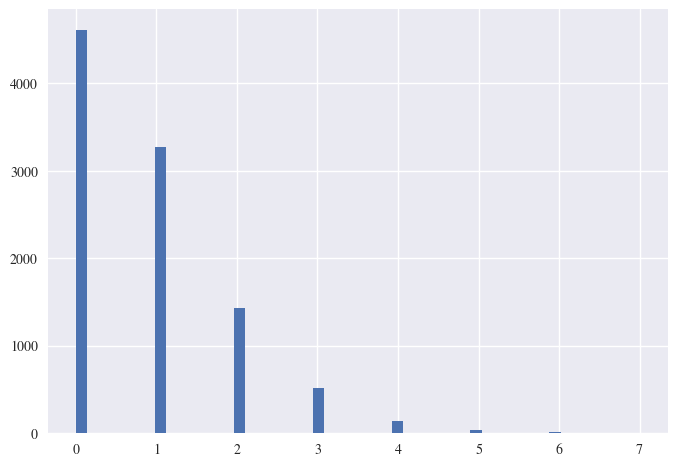

In [13]:
plt.hist(current_df["value"], bins=50)
plt.show()

In [14]:
proteins = {'Chlorophyta_34GX2', 'Escherichia_3XNQH', 'Rodentia_4Q41X', 'Paeruginosa_1YE0S', 'Bacillus_1ZS18', 'Tenericutes_3WUBT', 'Brassicales_3I0GE', 'Chlorophyta_34HB2', 'Rhabditida_40S9H', 'Drosophilidea_45V3E', 'Saccharomycetaceae_3S0RA', 'Chlorophyta_34H4K', 'Tenericutes_3WUF3', 'Rhizobiaceae_4B9GS', 'Escherichia_3XNRK', 'Drosophilidea_45RPU', 'Rodentia_4PS96', 'Rodentia_4PTGC', 'Rhabditida_40SE1', 'Tenericutes_3WT84', 'Bacillus_1ZDK0', 'Rodentia_4PYH5', 'Rhizobiaceae_4BC6A', 'Rhizobiaceae_4B75Q', 'Escherichia_3XP6Q', 'Vibrionales_1XTCX', 'Brassicales_3HXGM', 'Tenericutes_3WUCD', 'Rhabditida_40V2M', 'Drosophilidea_45SSP', 'Saccharomycetaceae_3RZMD', 'Brassicales_3HYYC', 'Vibrionales_1XTG6', 'Primates_4MARV', 'Escherichia_3XNG0', 'Escherichia_3XPHQ', 'Chlorophyta_34GR4', 'Primates_4M67P', 'Vibrionales_1XU15', 'Brassicales_3HTDJ', 'Rhabditida_40SFX', 'Drosophilidea_45P3P', 'Paeruginosa_1YFMH', 'Rhabditida_40TFR', 'Saccharomycetaceae_3RZJT', 'Brassicales_3HQ7D', 'Bacillus_1ZCEM', 'Ciliophora_3ZD1V', 'Tenericutes_3WTIB', 'Ciliophora_3ZATN', 'Primates_4MHCX', 'Saccharomycetaceae_3RZRX', 'Paeruginosa_1YF47', 'Staphylococcaceae_4GXGU', 'Staphylococcaceae_4GY1B', 'Vibrionales_1XUB6', 'Rodentia_4PVTR', 'Brassicales_3HWED', 'Tenericutes_3WT72', 'Escherichia_3XNH1', 'Drosophilidea_45WKQ', 'Brassicales_3HSNV', 'Drosophilidea_45RS0', 'Bacillus_1ZB8G', 'Bacillus_1ZQHG', 'Staphylococcaceae_4GX5X', 'Ciliophora_3ZB2V', 'Vibrionales_1XUED', 'Vibrionales_1XTP8', 'Saccharomycetaceae_3S03I', 'Brassicales_3HSQP', 'Rhizobiaceae_4BDG8', 'Ciliophora_3ZB2Z', 'Rhabditida_40RRZ', 'Rodentia_4PSEZ', 'Ciliophora_3ZB07', 'Bacillus_1ZPVT', 'Ciliophora_3ZB4R', 'Tenericutes_3WTTF', 'Escherichia_3XN02', 'Rhizobiaceae_4B9BS', 'Chlorophyta_34K42', 'Drosophilidea_45QQ6', 'Paeruginosa_1YERC', 'Tenericutes_3WUQ0', 'Primates_4MDYH', 'Chlorophyta_34GPX', 'Rodentia_4Q1G6', 'Tenericutes_3WT2C', 'Bacillus_1ZSAH', 'Vibrionales_1XUQD', 'Rodentia_4PTS1', 'Rodentia_4PTNH', 'Tenericutes_3WUCX', 'Rodentia_4PV81', 'Rodentia_4PY68', 'Escherichia_3XPCX', 'Saccharomycetaceae_3RYP9', 'Staphylococcaceae_4GXH0', 'Saccharomycetaceae_3RZN1', 'Paeruginosa_1YF4V', 'Tenericutes_3WT8G', 'Rodentia_4PTGV', 'Primates_4MRKW', 'Tenericutes_3WU9V', 'Ciliophora_3ZBD9', 'Bacillus_1ZAYH', 'Brassicales_3HWT2', 'Primates_4ME23', 'Drosophilidea_45WV7', 'Brassicales_3HZN3', 'Primates_4MM0D', 'Rhizobiaceae_4B8QY', 'Rhabditida_40TPY', 'Saccharomycetaceae_3RYRU', 'Escherichia_3XMH0', 'Brassicales_3HWPW', 'Drosophilidea_45SEE', 'Staphylococcaceae_4GX27', 'Primates_4MINA', 'Staphylococcaceae_4H1EV', 'Brassicales_3HXQA', 'Drosophilidea_45WR4', 'Paeruginosa_1YCT2', 'Escherichia_3XNKI'}

In [15]:
per_sum_stat_comparison = {
    "empirical":[0]*len(SUMSTATS_LIST),
    "simulated":[0]*len(SUMSTATS_LIST)
}
per_sum_stat_comparison_correction = {
    "empirical":[0]*len(SUMSTATS_LIST),
    "simulated":[0]*len(SUMSTATS_LIST)
}

per_dataset_comparison = {
    "empirical": 0,
    "simulated": 0
}
failed_sim_datasets = []

across_data_sims = np.zeros((125,27))

for idx,SELECTED_DATA in enumerate(proteins):
    EGGNOG_PATH = RESULTS_PATH / "eggnog" / SELECTED_DATA
    SIMS_PATH = next((RESULTS_PATH / "adequacy_sims").glob(f"{SELECTED_DATA}*"))
    _, EMPIRICAL_MSA_PATH = fetch_paths(EGGNOG_PATH)
    _, SIM_MSA_PATH = fetch_paths(SIMS_PATH)
    
    EMPIRICAL_MSA = Msa(str(EMPIRICAL_MSA_PATH))
    SIM_MSA = Msa(str(SIM_MSA_PATH))

    adequacy_eggnog = pd.read_csv(EGGNOG_PATH / "adequacy_revised/zipf_corrected.csv").drop(columns="Unnamed: 0")
    adequacy_sims = pd.read_csv(SIMS_PATH / "adequacy_revised/zipf_corrected.csv").drop(columns="Unnamed: 0")

    empirical_sum_stats = EMPIRICAL_MSA.get_sum_stats()
    empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))

    sim_sum_stats = SIM_MSA.get_sum_stats()
    sim_sum_stats = dict(zip(SUMSTATS_LIST, sim_sum_stats))



    empirical_percentile_summary = get_percentile_summary(adequacy_eggnog, empirical_sum_stats)
    sim_percentile_summary = get_percentile_summary(adequacy_sims, sim_sum_stats)

    failed_empirical = False
    failed_sim = False

    for stat_num in range(len(SUMSTATS_LIST)):
        stat_percentile = empirical_percentile_summary.iloc[stat_num,:].values[2]/100

        per_sum_stat_comparison["empirical"][stat_num] += (stat_percentile > p_val_limits[1] or stat_percentile < p_val_limits[0])
        per_sum_stat_comparison_correction["empirical"][stat_num] += (stat_percentile > p_val_limits_corrected[1] or stat_percentile < p_val_limits_corrected[0])

        failed_empirical = failed_empirical or (stat_percentile > p_val_limits_corrected[1]) or (stat_percentile < p_val_limits_corrected[0])

        stat_percentile = sim_percentile_summary.iloc[stat_num,:].values[2]/100

        per_sum_stat_comparison["simulated"][stat_num] += (stat_percentile > p_val_limits[1] or stat_percentile < p_val_limits[0])
        per_sum_stat_comparison_correction["simulated"][stat_num] += (stat_percentile > p_val_limits_corrected[1] or stat_percentile < p_val_limits_corrected[0])

        failed_sim = failed_sim or (stat_percentile > p_val_limits_corrected[1]) or (stat_percentile < p_val_limits_corrected[0])
        across_data_sims[idx,stat_num] = failed_sim

    # TODO:
    # make the comparison across datasets using the corrected p-value, if a single sumstat in a dataset does not fit indise the interval - it is rejected.
    per_dataset_comparison["empirical"] += failed_empirical
    per_dataset_comparison["simulated"] += failed_sim
    if failed_sim:
        failed_sim_datasets.append(SELECTED_DATA)

print(per_sum_stat_comparison)
print(per_sum_stat_comparison_correction)

print(per_dataset_comparison)


{'empirical': [51, 22, 33, 13, 53, 32, 23, 22, 50, 86, 45, 35, 10, 25, 21, 8, 4, 8, 13, 10, 32, 19, 15, 74, 71, 51, 56], 'simulated': [5, 0, 0, 2, 2, 3, 2, 3, 8, 5, 8, 4, 3, 2, 6, 4, 8, 6, 11, 12, 5, 8, 5, 3, 2, 4, 5]}
{'empirical': [18, 10, 17, 5, 33, 16, 11, 6, 24, 57, 33, 15, 1, 8, 5, 2, 0, 1, 0, 1, 16, 6, 2, 35, 40, 27, 29], 'simulated': [2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1]}
{'empirical': 103, 'simulated': 6}


<BarContainer object of 27 artists>

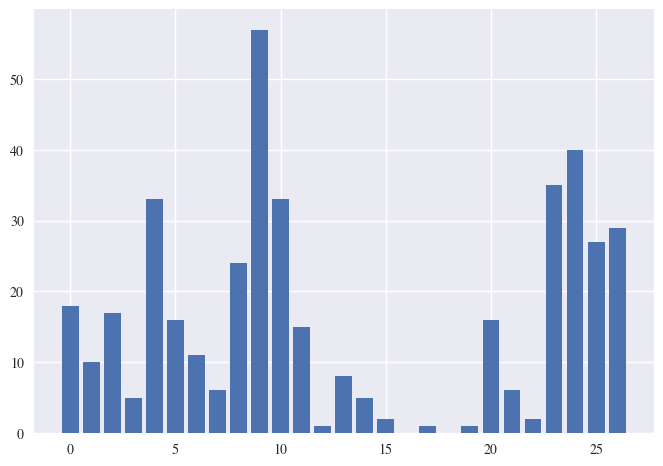

In [21]:
plt.bar(x=range(27),height=per_sum_stat_comparison_correction['empirical'])

<AxesSubplot: >

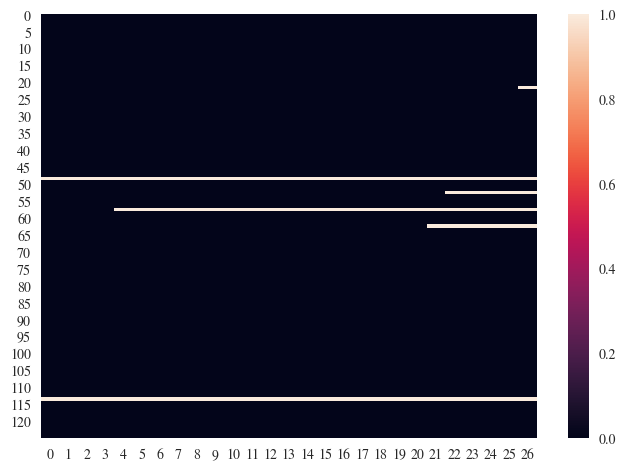

In [17]:
sns.heatmap(across_data_sims)

In [18]:
failed_sim_datasets

['Primates_4MINA',
 'Brassicales_3HYYC',
 'Saccharomycetaceae_3S0RA',
 'Ciliophora_3ZB2Z',
 'Rodentia_4PTGC',
 'Escherichia_3XNKI']

<AxesSubplot: >

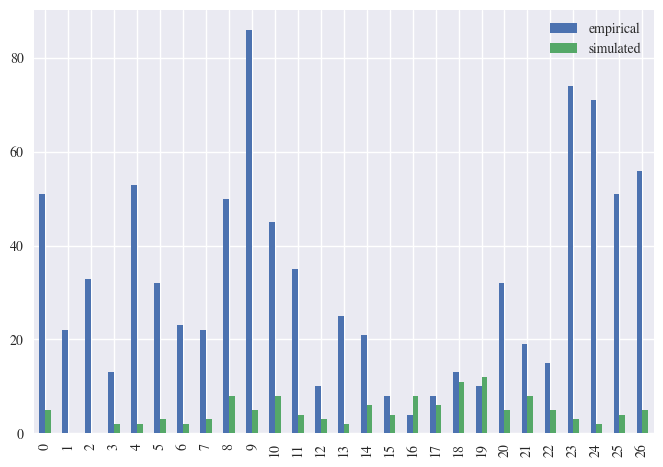

In [19]:
pd.DataFrame(per_sum_stat_comparison).plot(kind="bar")

<AxesSubplot: >

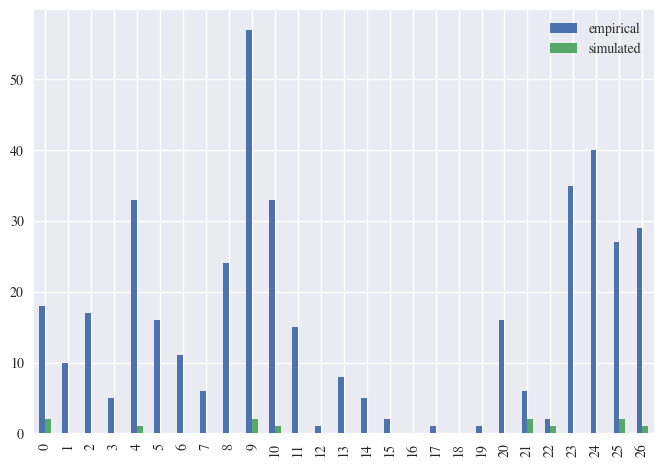

In [20]:
pd.DataFrame(per_sum_stat_comparison_correction).plot(kind="bar")